# Wetland water depth analyses <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI`|`DEA Sandbox` environment
* **Products used:** 

* **Special requirements:** An _optional_ description of any special requirements, e.g. If running on the [NCI](https://nci.org.au/), ensure that `module load otps` is run prior to launching this notebook
* **Prerequisites:** An _optional_ list of any notebooks that should be run or content that should be understood prior to launching this notebook

In [114]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import sys
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
import rasterio.features
import datacube
import scipy.signal, scipy.ndimage

sys.path.append('Scripts')
from dea_datahandling import load_ard
from dea_bandindices import calculate_indices
from dea_spatialtools import subpixel_contours

%load_ext autoreload
%autoreload 2

In [2]:
def get_water_level(geom, dem, x_offsets=[0], y_offsets=[0]):  
        
    '''
    Takes a shapely geometry (either LineString or MultiLineString) and a Digital Elevation
    Model (DEM), and samples values from the DEM based on line vertices. These values are used
    to return the median and standard deviation of elevation, which can subsequently be used
    to compute volume (and uncertainty) based on the same DEM.
    
    Optionally, this function can be run with a set of x and y offset values, which shuffle 
    the geometry object left, right, up and down, and returns values for the combination 
    with the lowest standard deviation. This is intended to account for 'jitter' caused by 
    poor co-registration/georeferencing in the Sentinel 2 imagery. This is experimental, and
    should be used with caution.
    
    Last modified: March 2019
    Author: Robbi Bishop-Taylor
    
    Parameters
    ----------    
    geom : Shapely LineString or MultiLineString
        Shapely geometry for the waterline being analysed
    dem : array
        A 2D digital elevation model (DEM) in the form of a numpy or xarray array.
    x_offsets : list, optional
        A list giving a series of amounts in metre units to shuffle the geometry east and west.
        The default is [0], which does no shuffling. E.g. setting `x_offsets=[-10, 0, 10]`
        will shuffle the geometry west and east by 10 m, and return results for the offset which
        produces the lowest standard deviation in extracted elevation values.
    y_offsets : list, optional
        A list giving a series of amounts in metre units to shuffle the geometry north and south.
        The default is [0], which does no shuffling. E.g. setting `y_offsets=[-10, 0, 10]`
        will shuffle the geometry north and south by 10 m, and return results for the offset which
        produces the lowest standard deviation in extracted elevation values.
        
    Returns
    -------
    offset_min_std : Pandas DataFrame
        A Pandas dataframe with columns giving `x_offset', 'y_offset`, `water_level` and 
        `water_level_std` values. `x_offset', 'y_offset` give the offset values which resulted
        in the lowest standard deviation of elevation values, while `water_level` and 
        `water_level_std` return the corresponding median and standard deviation elevation values
        themselves.
    '''
    
    # First try extracting line vertex coordinates from a Shapely LineString
    try: 
        xx, yy = geom.coords.xy
        xx = np.array(xx)
        yy = np.array(yy)

    # If this fails, extract line vertex coordinates as if data is a Shapely MultiLineString
    except:

        xx = np.concatenate([i.coords.xy[0] for i in geom])
        yy = np.concatenate([i.coords.xy[1] for i in geom]) 
        
    # Convert coordinates to xarray DataArrays to facilitate fast extraction of elevation values
    xx = xr.DataArray(xx, dims='z')
    yy = xr.DataArray(yy, dims='z')
    
    # Iterate through all combinations of x and y offsets
    all_offsets = []    

    for x_offset, y_offset in itertools.product(x_offsets, y_offsets):        

        # Sample DEM to extract elevations for each vertex coordinate
        sampled_elevs = dem.interp(x=xx + x_offset, y=yy + y_offset).values

        # Compute median and standard deviation elevation values, and add to list
        all_offsets.append(((x_offset, y_offset, np.nanmedian(sampled_elevs), np.nanstd(sampled_elevs))))

    # From the dataframe of resulting water_levels and water_level_stds for different xy offsets, 
    # select the row with the lowest standard deviation in elevation values.
    offset_df = pd.DataFrame(all_offsets, columns=['x_offset', 'y_offset', 
                                                   'water_level', 'water_level_std'])
    offset_min_std = offset_df.iloc[offset_df.water_level_std.idxmin()]

    return offset_min_std 


def level_to_volume(level_m, dem, resolution, clip_max=True):
    
    '''
    Applies a given water level to a DEM, and computes the total volume
    of the area filled with water in megalitre (Ml) units.
    
    Last modified: March 2019
    Author: Robbi Bishop-Taylor
    
    Parameters
    ----------    
    level_m : int or float
        Water level of dam/reservoir in metre units.
    dem : array
        A 2D digital elevation model (DEM) in the form of a numpy or xarray array.
    resolution : tuple
        A tuple giving the x and y resolutions of the DEM.
    clip_max : bool, optional
        An optional boolean indicating whether to restrict water levels to the highest 
        elevation in the DEM. The default is True, which prevents artificially high
        volumes being computed where water levels are higher than the top of the dam.
        
    Returns
    -------
    total_volume : int or float
        A numeric value giving the computed volume in megalitre (Ml) units
    '''
    
    # If water level is above highest point in DEM, use the highest elevation in 
    # the DEM instead of the supplied water level
    if clip_max:
        level_m = np.min([level_m, dem.max().item()])
        
    # Create a flat array with values set to the given water level
    water_level = np.full(dem.shape[1:], level_m)
    
    # Subtract LiDAR DEM from this water level array to create an array giving the 
    # difference between this water level and the true elevation of each pixel
    water_level_diffs = water_level - dem
    
    # By restricting these differences to only pixels where the water level is
    # higher than the underlying LiDAR DEM (i.e. positive values), we can get
    # depths for every pixel
    water_level_depths = water_level_diffs.where(water_level_diffs > 0)
    
    # By multiplying depths by the area of each pixel (obtained from the resolution
    # of the LiDAR raster), we can compute volumes in cubic metres for each pixel
    water_level_volumes = water_level_depths * (resolution[0] * resolution[1])   
    
    # Finally, sum the volumes of all pixels and multiply by 0.001 to get total 
    # waterbody volume in megaliters (Ml) for the given water level height
    total_volume = water_level_volumes.sum().item() * 0.001

    # Return volume     
    return total_volume


def identify_outliers(data, m = 3):
    
    '''
    Function takes an array of values, and returns a boolean array
    of the same length which flags values as outliers according to the 
    standard deviation m. 
    '''
    
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d / mdev if mdev else 0.
    return s < m



In [3]:
dc = datacube.Datacube(app='Waterbody_volumes')

## Reproject Geotiff

In [132]:
LiDAR = xr.open_rasterio('MacquarieMarshes2008_5626556_01_0023577.tif')

### Filter out missing values
For some reason, this GeoTiff has used a stupidly large negative number to represent missing values. We need to remove these so we can actually use the data properly.

In [133]:
LiDARFiltered = LiDAR.where(LiDAR>=-5000)
LiDARFilteredDA = xr.DataArray(LiDARFiltered.squeeze(),
                                  coords=[LiDARFiltered.y, LiDARFiltered.x],
                                  dims=['y', 'x'],
                                  name='DEM',
                                  attrs=LiDARFiltered.attrs)
LiDARFilteredDS = LiDARFilteredDA.to_dataset()
LiDARFilteredDSAnom = LiDARFilteredDS.DEM - LiDARFilteredDS.DEM.min()
LiDARFilteredDSAnom.attrs = LiDAR.attrs

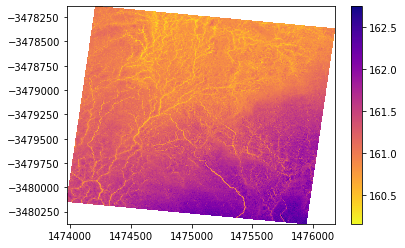

In [138]:
plt.pcolor(LiDARFilteredDS.x, LiDARFilteredDS.y, LiDARFilteredDS.DEM, cmap='plasma_r')#, vmin=0, vmax=1)
plt.colorbar()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  """


Text(0.5, 0, 'Elevation (m above local lowest point)')

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


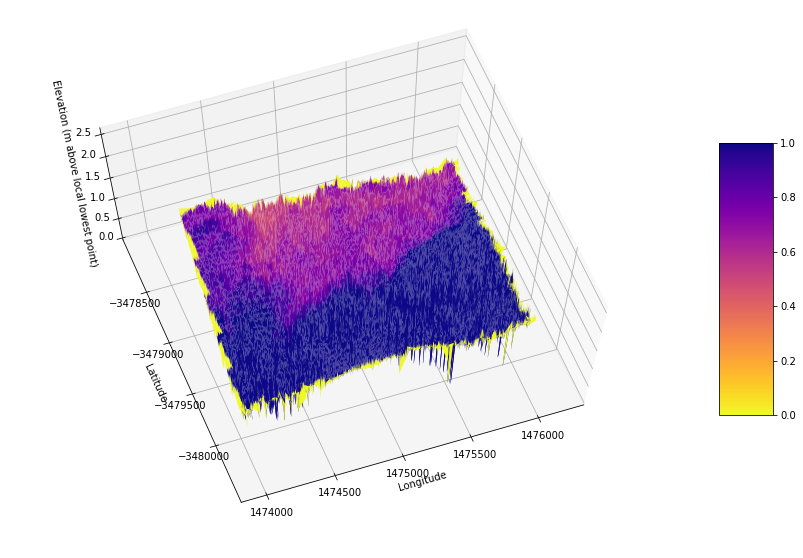

In [135]:
XX, YY = np.meshgrid(LiDARFilteredDS.x, LiDARFilteredDS.y)

fig = plt.figure(figsize=[15,10])
ax = fig.gca(projection='3d')
surf = ax.plot_surface(XX, YY, LiDARFilteredDSAnom, cmap='plasma_r', vmin=0, vmax=1)
# Change so that N is in the right place
ax.view_init(70,-110)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Elevation (m above local lowest point)', rotation=180)

## VegComm 
from https://datasets.seed.nsw.gov.au/dataset/macquarie-marshes-vegetation1991-2008-vis_id-3920ff230/resource/3f102578-05ba-4a59-854d-fddd9ab27f53

`!ogr2ogr -t_srs EPSG:3577 MacquarieMarshes_2008_E_39203577.shp MacquarieMarshes_2008_E_3920.shp`

In [8]:
VegComm = gpd.read_file('MacquarieMarshes_2008_E_39203577.shp') 

## Now we need to create a mask from the extents of the LiDAR data

In [9]:
# Grab the lat and lon extents of the LiDAR dataset
# Note that there are 5 pairs here - four corners plus back to the start
latextents=[LiDARFiltered.x.min().item(), LiDARFiltered.x.min().item(), LiDARFiltered.x.max().item(), LiDARFiltered.x.max().item(), LiDARFiltered.x.min().item()]
lonextents=[LiDARFiltered.y.max().item(), LiDARFiltered.y.min().item(), LiDARFiltered.y.min().item(), LiDARFiltered.y.max().item(), LiDARFiltered.y.max().item()]
# Turn those coordinates into a polygon
polygon_geom = Polygon(zip(latextents, lonextents))

# Create a geodataframe with just our new extent polygon
df = gpd.GeoDataFrame(gpd.GeoSeries(polygon_geom), columns=['geometry'], crs='EPSG:3577')

## Now clip the shapefile with the extents of the raster

In [10]:
ClippedVeg = gpd.clip(VegComm, df)

/usr/local/lib/python3.6/dist-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


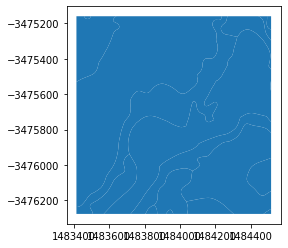

In [11]:
ClippedVeg.plot()

### Assign a random UID for each species

In [12]:
ClippedVeg['RandomUID'] = ClippedVeg.groupby('Species_1').ngroup()

unique_combinations = ClippedVeg[['RandomUID', 'Species_1']].drop_duplicates()
SpeciesDict = dict(zip(unique_combinations.RandomUID, unique_combinations.Species_1))

### Rasterize the shapefile

In [13]:
shapes = zip(ClippedVeg['geometry'], ClippedVeg['RandomUID'])
# First grab the spatial information from our datacube xarray object
transform = LiDARFiltered.attrs['transform']
y, x = LiDARFiltered.squeeze().values.shape

# Now convert the polgons into a numpy array
RasterVeg = rasterio.features.rasterize(shapes=shapes,
                                                 out_shape=(y, x),
                                                 all_touched=False,
                                                 fill=np.nan,
                                                 transform=transform)

# Convert result to a xarray.DataArray using coords etc from original dc.load dataset
RasterVeg = xr.DataArray(RasterVeg,
                                  coords=[LiDARFiltered.y, LiDARFiltered.x],
                                  dims=['y', 'x'],
                                  name='veg_randomUID',
                                  attrs=LiDARFiltered.attrs)

# Convert to xarray dataset to assist with writing to GeoTIFF
RasterVeg = RasterVeg.to_dataset()
RasterVeg.attrs = LiDARFiltered.attrs

In [14]:
CombineLiDARVeg = RasterVeg.merge(LiDARFilteredDS)

Text(0, 0.5, 'Elevation (masl)')

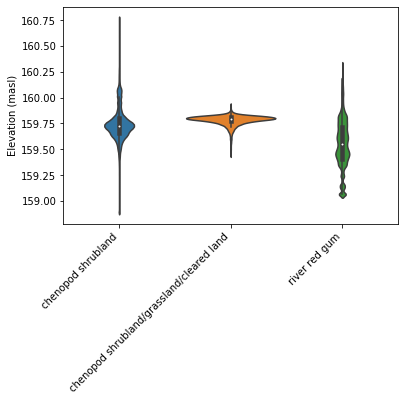

In [15]:
ax = sns.violinplot(x=CombineLiDARVeg['veg_randomUID'].values.flatten(), y=CombineLiDARVeg['DEM'].values.flatten())
ax.set_xticklabels(sorted(SpeciesDict.values()), rotation=45, ha='right');
plt.ylabel('Elevation (masl)')

## Can we automatically detect water in the lidar data?

From the lidar plots above, we can see that there are large flat bits of data that are either water, or very flat streambeds. Can we develop some code to automatically detect the presence of water in the lidar data, and therefore introduce a degree of uncertainty to our volume results?

The code below does this by looking for large flat areas within the lidar data. It first takes the DEM, then calculates the difference between subsequent values in both the x and y direction. It then compares these differences to the `flatness_threshold`, which sets how much variability in the DEM we are considering to be 'flat'. This allows for some small variance to still be considered a uniform flat surface. 

Once we've determined where the data are sufficiently 'flat', the data are smoothed using `scipy.signal.convolve2d`, then small 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less_equal
  del sys.path[0]


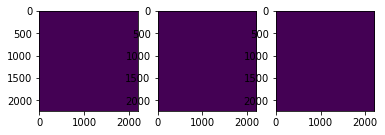

In [136]:
# How flat? This is in the same units as the DEM
flatness_threshold = 0 

# How many times do we need to see the value in the data?
# e.g. if we have a 
count_threshold = 1000 #900  # How big?

# Check whether subsequent numbers are the same to determine the gradient of the DEM
x = np.diff(LiDARFilteredDS.DEM, axis=1)
y = np.diff(LiDARFilteredDS.DEM, axis=0)

# Is the difference small enough to be considered 'flat'?
z = (np.absolute(x) <= flatness_threshold)[1:] & (np.absolute(y) <= flatness_threshold)[:,1:]
# Does some initial smoothing
z = scipy.signal.convolve2d(z, np.ones((2, 2))) == 4
# Erodes and then dilates the data to remove small 'bits'
z = scipy.ndimage.binary_opening(z, iterations=1)

# Find how many unique numbers are in the data (within the z mask), and count their occurance
val, count = np.unique(LiDARFilteredDS.DEM.values[z], return_counts=True)
# Compare the count to the count threshold
val = val[count > count_threshold]
# Just return data where it reaches the count threshold
dupes = np.isin(LiDARFilteredDS.DEM, val)

plt.subplot(1, 3, 1).imshow(z);
plt.subplot(1, 3, 2).imshow(dupes);
plt.subplot(1, 3, 3).imshow(LiDARFilteredDS.DEM == 159.73);

(LiDARFilteredDS.DEM==159.73).sum(), [(LiDARFilteredDS.DEM==i).sum() for i in val];

In [128]:
LiDARFilteredDS.DEM.values[z]

array([159.49, 159.49, 159.49, ..., 159.77, 159.77, 159.77], dtype=float32)

## Load in some Landsat data and calculate water index

In [18]:
minimum_cloudfree_perc = 0.5  # Minimum proportion of cloud free pixels used to return cloud-free images
waterindex_thresh = 0.0  # The threshold to seperate water vs. non water using the MNDWI index
time_period = ('2015', '2017')  # Time period to analyse using Sentinel 2A and 2B

In [19]:
# Get spatial extent bounds from dimensions of LiDAR data
ymin = LiDAR.y.min().item()
ymax = LiDAR.y.max().item()
xmin = LiDAR.x.min().item()
xmax = LiDAR.x.max().item()

query = {'x': (xmin, xmax),
         'y': (ymax, ymin),
         'time': time_period,
         'crs': LiDAR.crs,
#          'measurements': ['nbart_green', 'nbart_swir_2', 'nbart_nir_1'],
         'measurements': ['nbart_green', 'nbart_swir_1', 'nbart_nir'],
         'resolution': (-100, 100),
         'output_crs': LiDAR.crs,
         'resampling': {'fmask': 'nearest', '*': 'average'}, 
        }

# Load in only Sentinel 2 observations with less than X percent clear pixels
satellite_ds = load_ard(dc=dc, 
#                         products=['s2a_ard_granule', 's2b_ard_granule'],
                        products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
                        min_gooddata=minimum_cloudfree_perc,
                        **query)

Loading ga_ls5t_ard_3 data
    No data for ga_ls5t_ard_3
Loading ga_ls7e_ard_3 data
    Filtering to 92 out of 115 observations
    Applying pixel quality mask
Loading ga_ls8c_ard_3 data
    Filtering to 118 out of 135 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 210 observations 


In [20]:
# Compute Modified Normalised Difference Water Index (MNDWI)
satellite_ds = calculate_indices(satellite_ds, 
                                 index='MNDWI', 
#                                  collection='ga_s2_1'
                                 collection='ga_ls_3'
                                )

# Drop outliers caused by unflagged cloud (i.e. any timestep 3 standard 
# deviations above the median water pixels AND > 50% water pixels)
water_prop = (satellite_ds.MNDWI > 0).mean(dim = ['x', 'y'])
outliers_bool = identify_outliers(water_prop, m = 3)
satellite_ds = satellite_ds.sel(time = outliers_bool | (water_prop < 0.5))

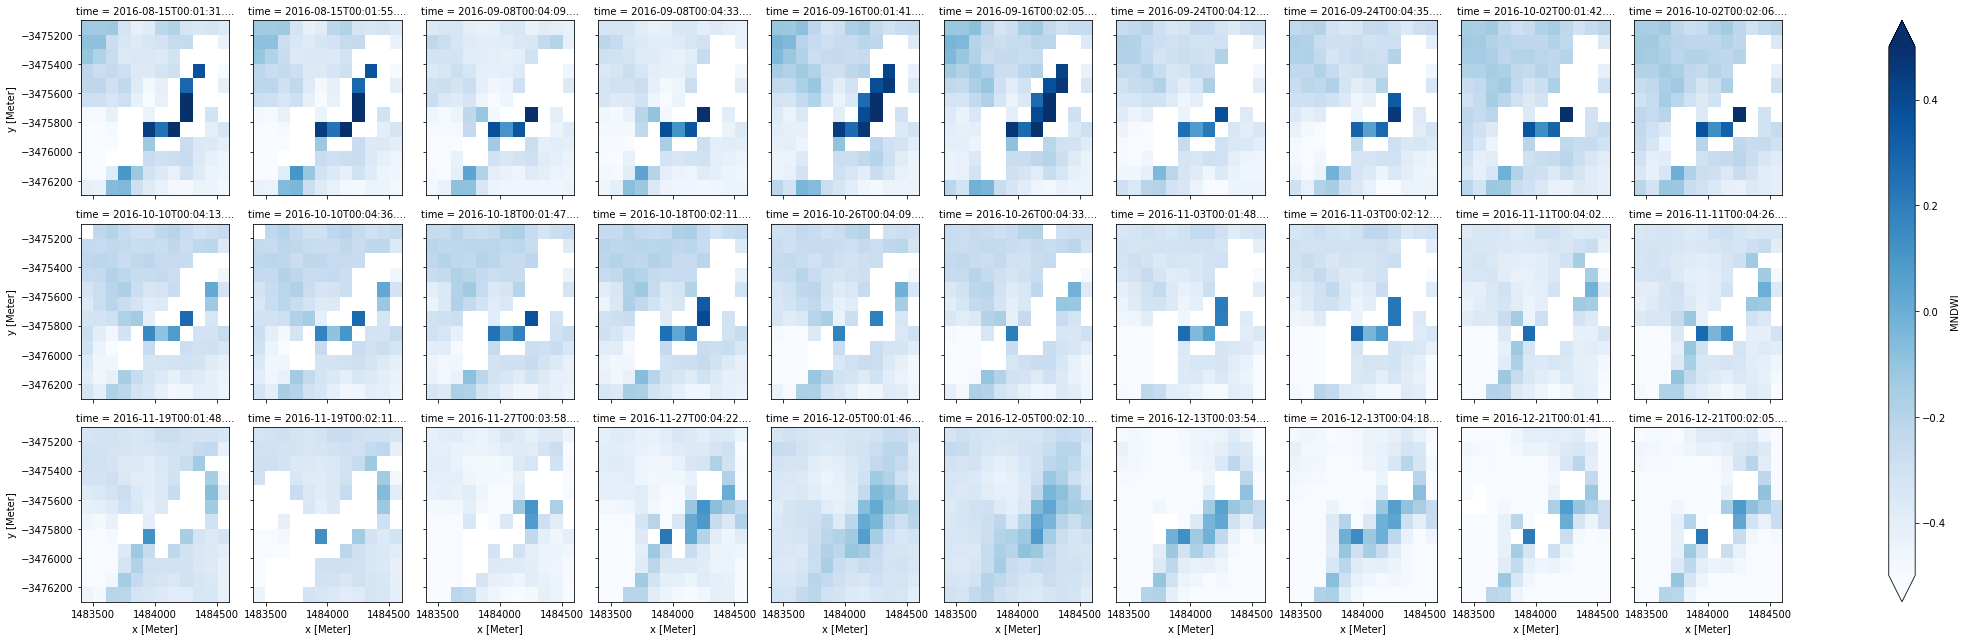

In [21]:
# Preview results for the first 30 observations
satellite_ds.MNDWI.isel(time=slice(100, 130)).plot.imshow(col='time',
                                                       col_wrap=10,
                                                       vmin=-0.5, 
                                                       vmax=0.5,
                                                       cmap='Blues',
                                                       add_labels=False)

## Extract depth contours from the LiDAR

Operating in multiple z-value, single array mode


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)


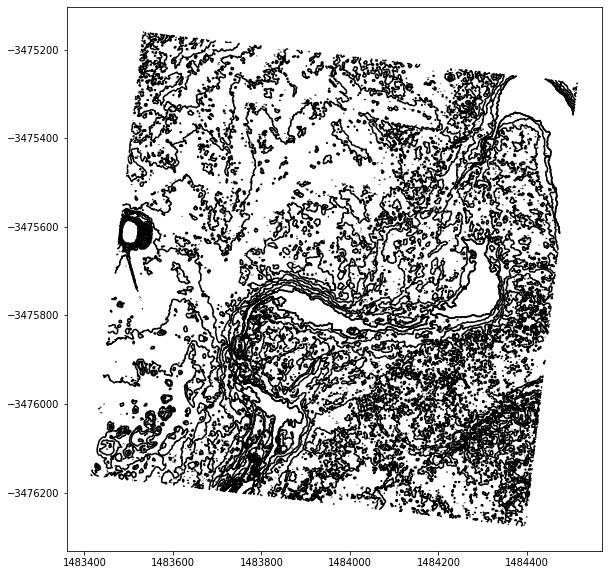

In [106]:
# Extract waterline contours for the supplied water index threshold:
contour_gdf = subpixel_contours(da=LiDARFilteredDS.DEM,                               
                                z_values= np.arange(start=LiDARFilteredDS.DEM.min(), stop=LiDARFilteredDS.DEM.max(), step=0.10).tolist(),
                                crs=LiDARFilteredDS.geobox.transform)

# Clip contours to extent of waterbody polygon. This prevents the waterlines 
# including portions of neighbouring waterbodies or surrounding naturally wet
# terrain, which would introduce uncertainty into extracted water level estimates.
# Because this may delete some contours entirely, we then filter to keep only
# contours that have data after the clip.
# contour_gdf['geometry'] = contour_gdf.intersection(ClippedVeg.unary_union)
# contour_gdf = contour_gdf[[True if i else False for i in contour_gdf.geometry]]
contour_gdf.plot(figsize=(10, 10), color = 'k')

### Plot some Landsat data over the top to show the scale of each dataset

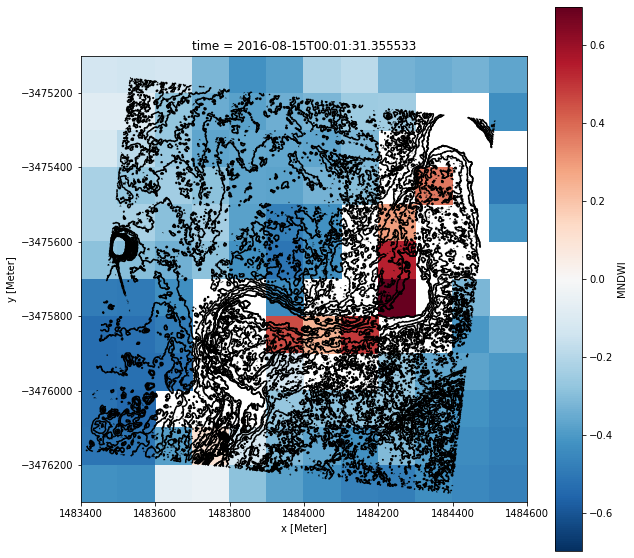

In [107]:
contour_gdf.plot(figsize=(10, 10), color = 'k')
satellite_ds.MNDWI.isel(time=100).plot()